In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
softThreshold(u,μ) = (sign.(u) .* max.(abs.(u) .- μ, 0))
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)))
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

In [4]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, LinearAlgebra, Distances
using Plots

In [5]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
nev                    = 10;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [6]:
T(x,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
          rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [7]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

  2.515782 seconds (13.17 M allocations: 561.504 MiB, 5.13% gc time)


In [10]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [11]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

  2.559598 seconds (17.01 M allocations: 831.185 MiB, 6.88% gc time)


In [12]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  3.085785 seconds (9.35 M allocations: 557.558 MiB, 3.34% gc time)


In [13]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [14]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  1.361296 seconds (4.40 M allocations: 253.513 MiB, 4.25% gc time)
  0.095710 seconds (65.91 k allocations: 43.309 MiB, 21.19% gc time)
  0.064104 seconds (292 allocations: 39.675 MiB)
  0.063469 seconds (292 allocations: 39.675 MiB)
  0.072690 seconds (298 allocations: 39.676 MiB, 12.93% gc time)
  0.062926 seconds (292 allocations: 39.675 MiB)
  0.070920 seconds (296 allocations: 39.676 MiB, 9.31% gc time)
  0.065303 seconds (292 allocations: 39.675 MiB)
  0.063795 seconds (292 allocations: 39.675 MiB)
  0.061902 seconds (292 allocations: 39.675 MiB)


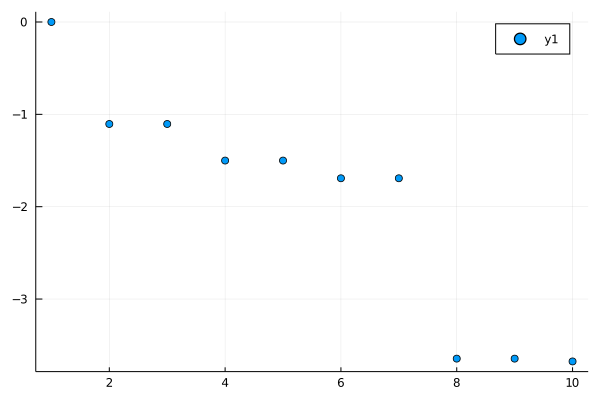

In [15]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [16]:
# gap after 7
nev = 7
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [17]:
color =    :balance
xticks =   0:2π:2π
yticks =   0:2π:2π
colorbar = :left
cmins =     [-0.3, -0.3, -0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]
cmaxs =     -1 .*cmins
cmins_lr =  [-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
cmaxs_lr =  -1 .*cmins_lr;

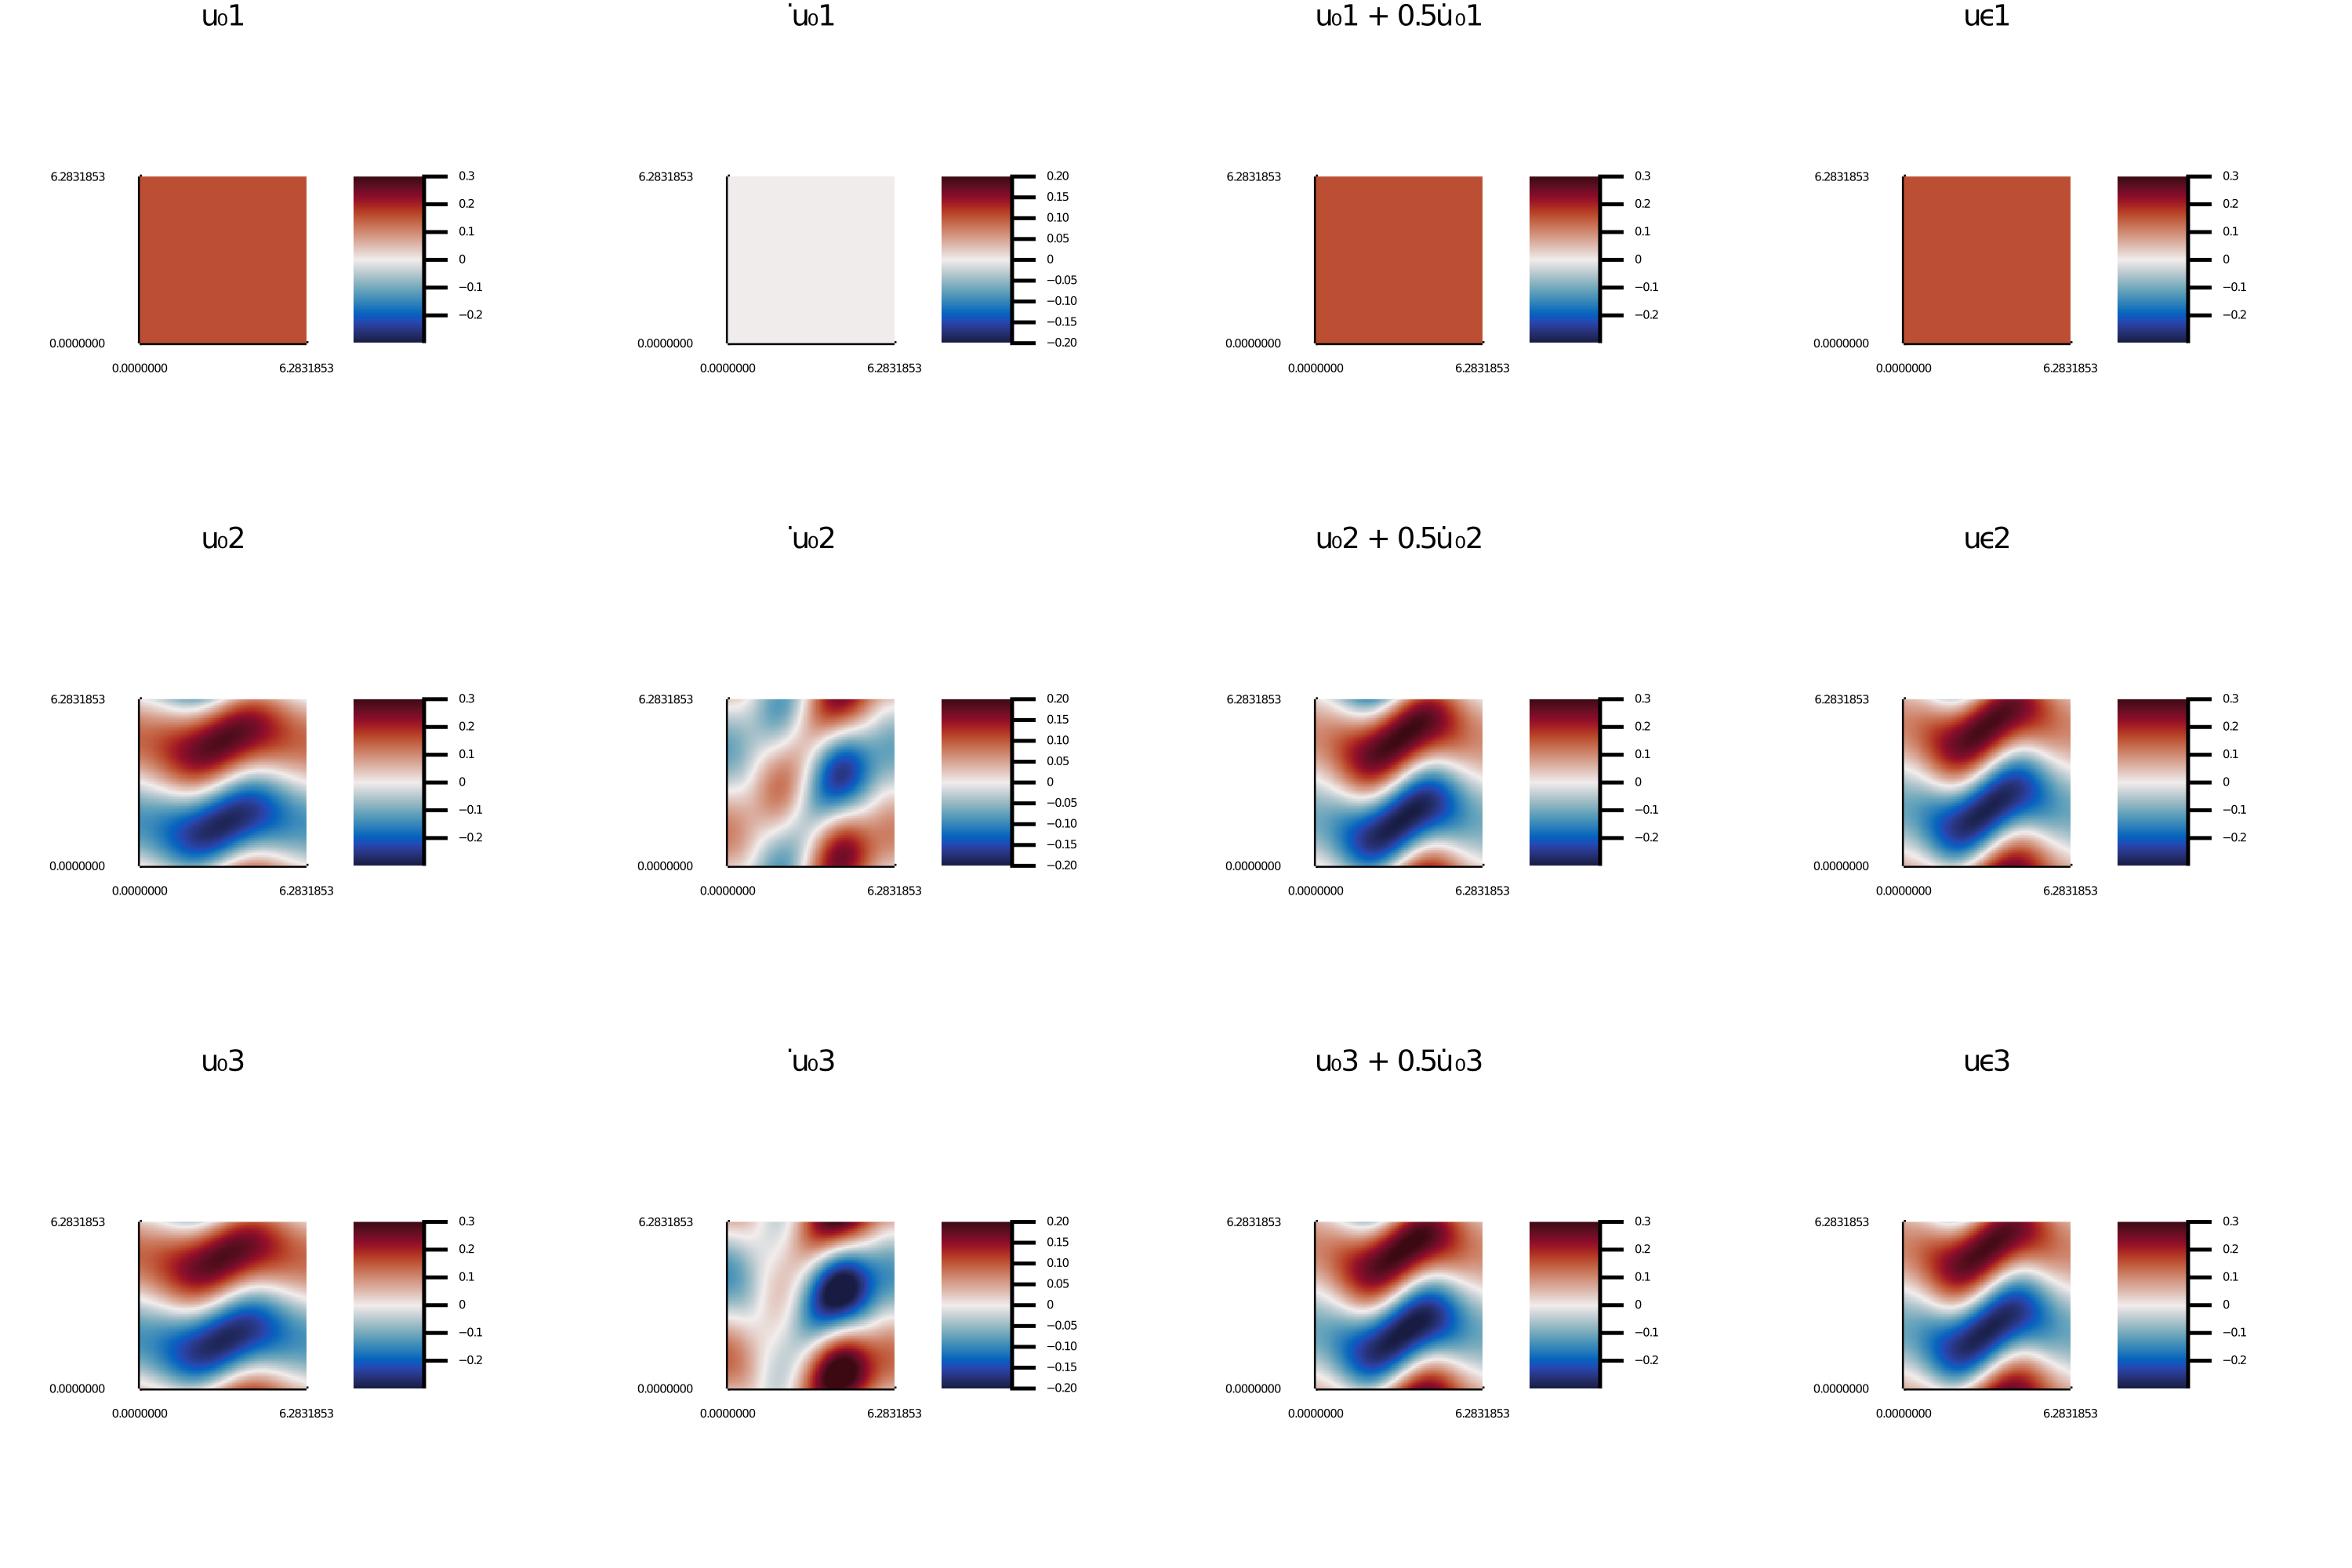

In [18]:
plots = []
for i in 1:3
    push!(plots,plot_u(ctx, u₀[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(3,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

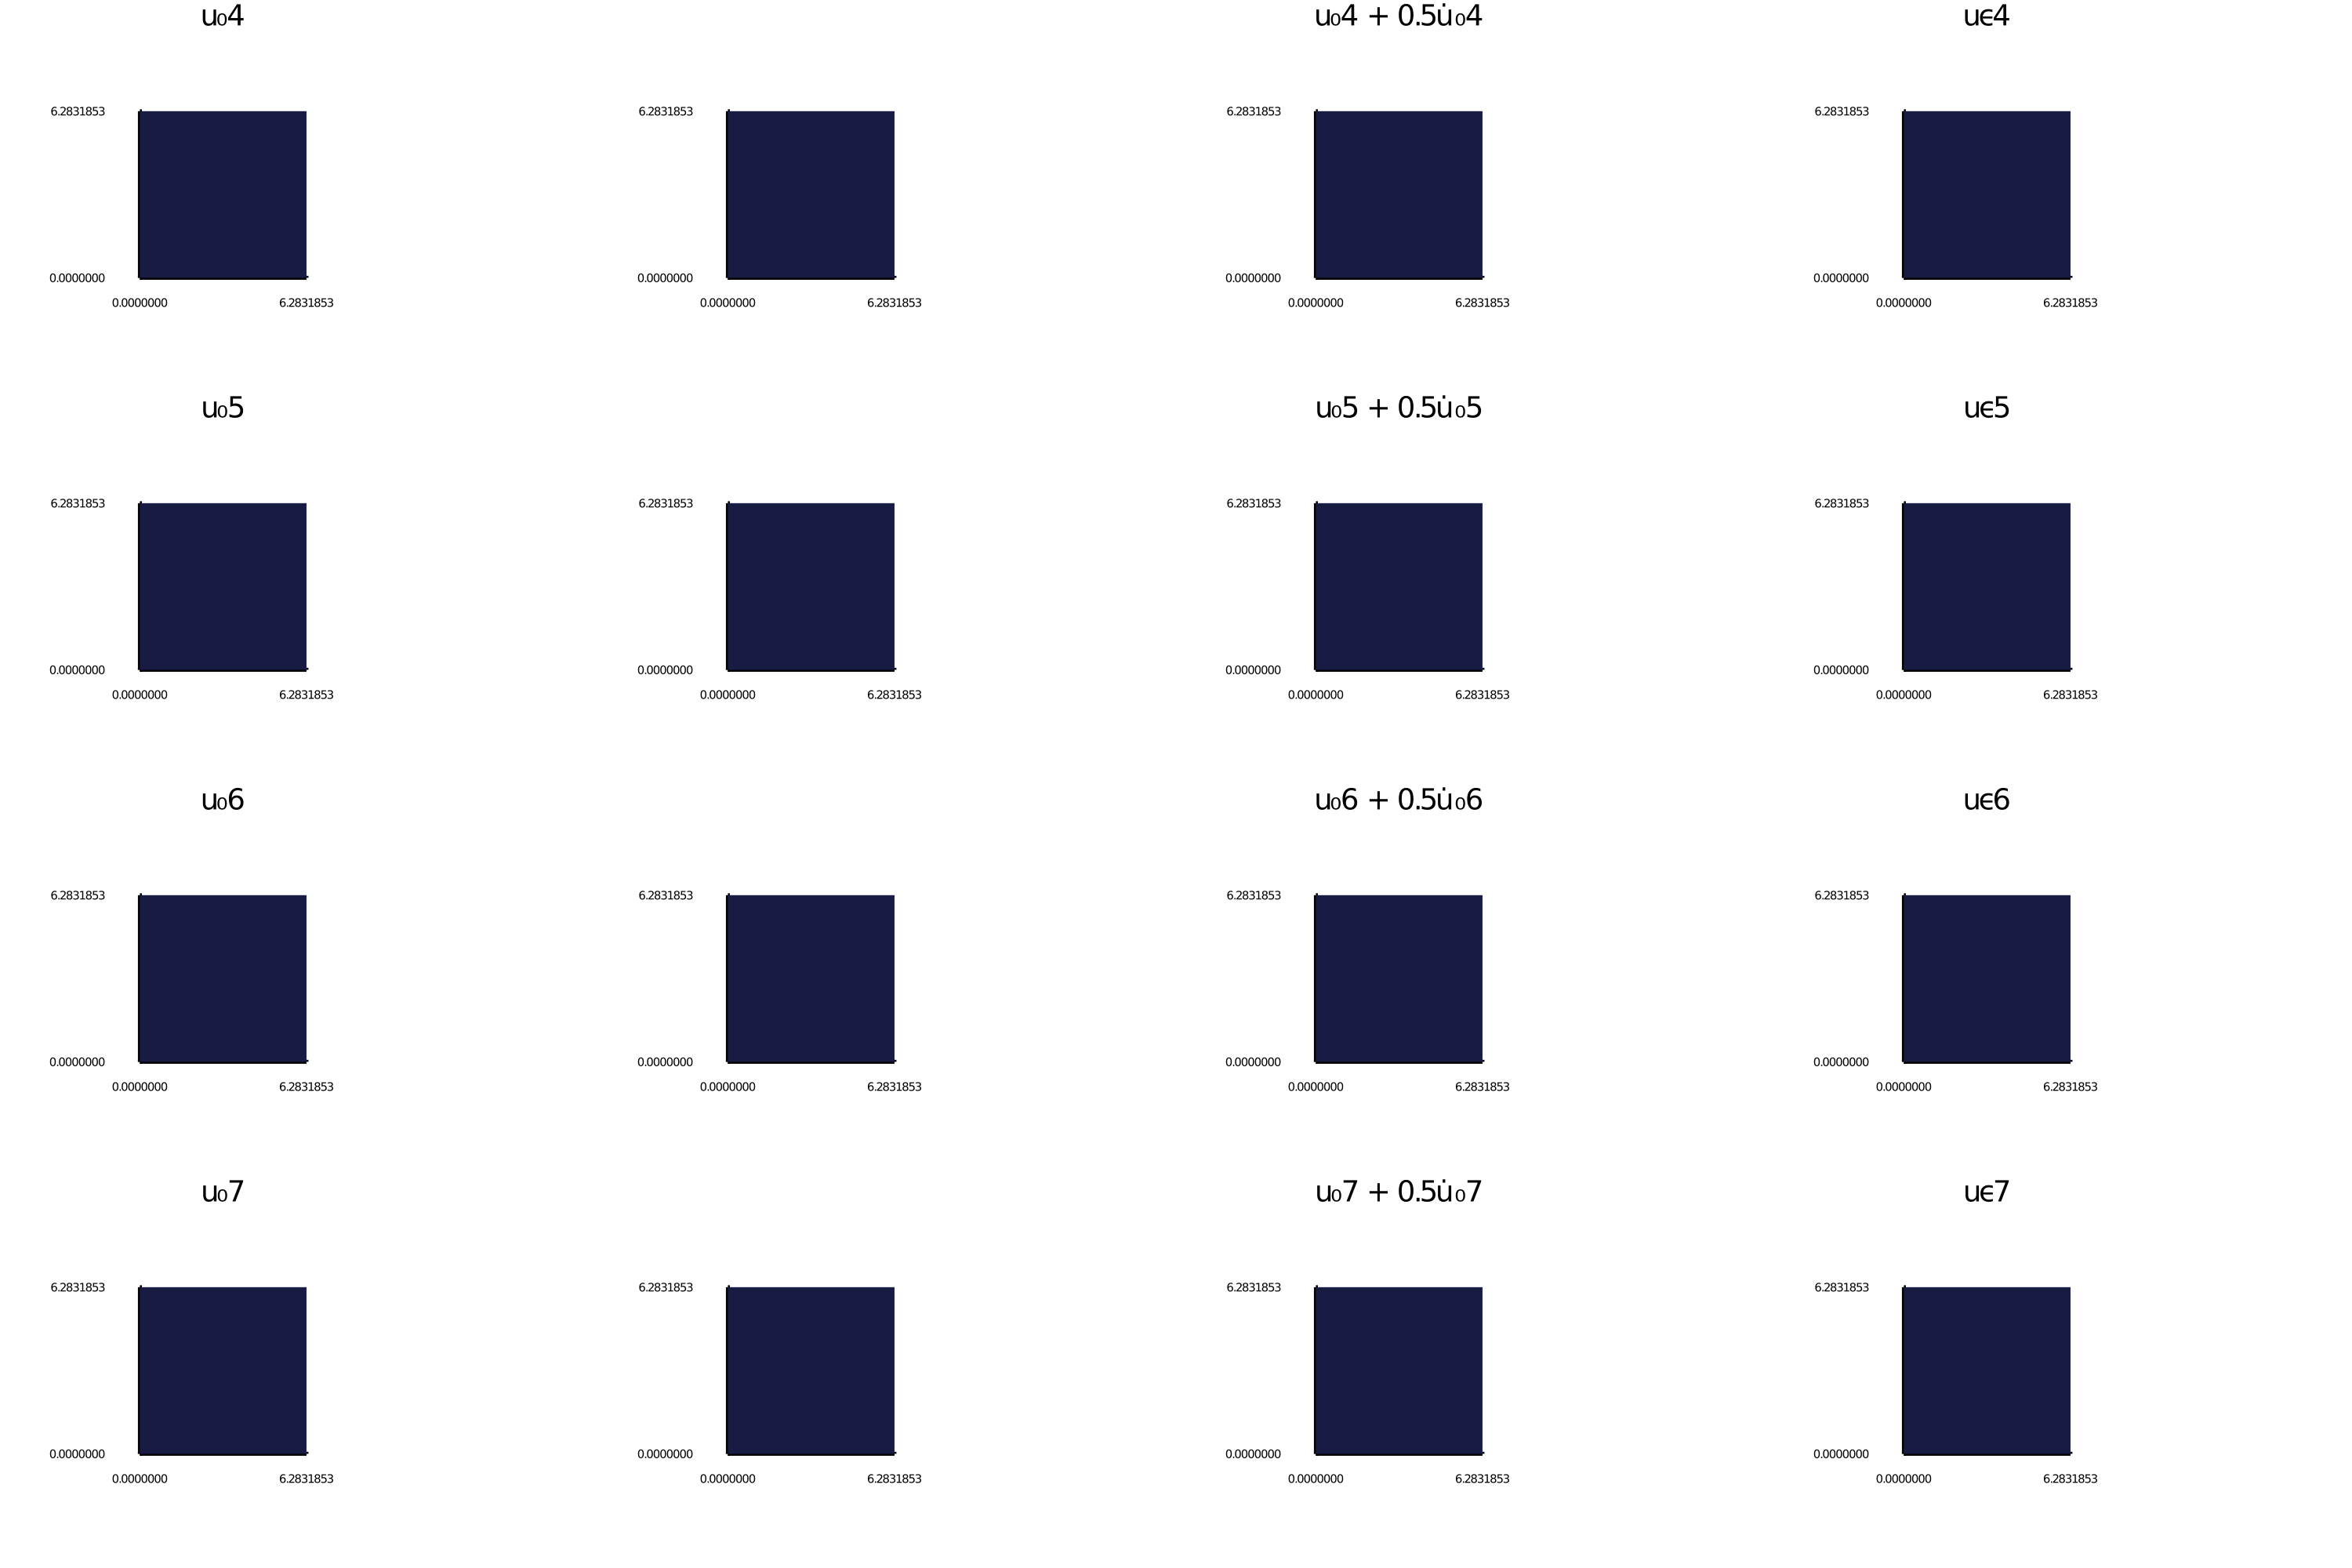

GKS: Possible loss of precision in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is invalid in routine SET_WINDOW
GKS: Rectangle definition is invalid in routine CELLARRAY
invalid range
GKS: Rectangle definition is 

In [19]:
plots = []
for i in 4:nev
    push!(plots,plot_u(ctx, u₀[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            titl
            =colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev-3,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [20]:
using Contour
using StaticArrays

In [21]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [22]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T_static(x),tolerance=1e-10)
end

dynamic_cheeger_value_levelset (generic function with 1 method)

In [23]:
ev = 3;

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13952968320911793)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.1389590106382979)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13838833806747786)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13781766549665783)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.1372469929258378)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13667632035501778)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13610564778419776)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13553497521337773)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.1349643026425

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08645713412285534)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08588646155203532)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0853157889812153)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08474511641039525)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08417444383957523)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0836037712687552)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08303309869793518)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08246242612711514)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0818917535562

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.039091310744793044)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03852063817397301)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03794996560315299)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03737929303233296)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03680862046151293)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0362379478906929)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.035667275319872876)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.035096602749052845)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.034525930

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.011698548058189427)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.012269220629009455)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.012839893199829483)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01341056577064951)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.013981238341469538)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.014551910912289566)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.015122583483109594)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01569325605392962)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01626392862474

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.062488406861171894)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06305907943199192)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06362975200281196)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06420042457363198)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.064771097144452)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06534176971527203)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06591244228609207)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06648311485691209)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06705378742773212)
└ 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11441961080579442)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11499028337661445)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11556095594743447)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1161316285182545)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11670230108907453)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11727297365989456)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11784364623071458)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11841431880153461)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11898499137235465)
└ 

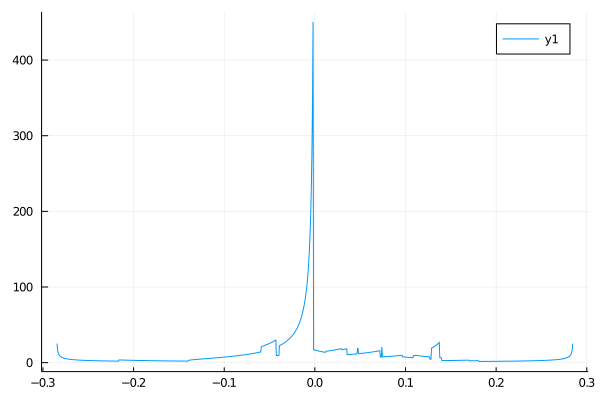

In [24]:
u_max = maximum(u₀[:,ev])
u_min = minimum(u₀[:,ev])
values = []
for c in range(u_min,stop=u_max,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c, bdata=bdata)
    if (length(lines(levelset))>0)
        push!(values,dynamic_cheeger_value_levelset(levelset))
    else 
        push!(values,0)
    end
end
Plots.plot(range(u_min,stop=u_max,length=1000)[2:end-1],values[2:end-1])

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.1398204354679773)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13925090310209398)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13868137073621065)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.1381118383703273)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.137542306004444)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13697277363856067)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13640324127267736)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.13583370890679403)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.135264176540910

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.09027111963612808)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08970158727024474)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08913205490436144)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0885625225384781)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08799299017259476)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08742345780671146)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08685392544082812)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.08628439307494482)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.085714860709

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.04072180380427887)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.04015227143839553)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.039582739072512196)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03901320670662889)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.038443674340745554)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03787414197486222)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03730460960897891)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.036735077243095576)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03616554

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.008827512027570372)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.00939704439345368)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.009966576759337042)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01053610912522035)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.011105641491103657)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.011675173856986965)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.012244706222870327)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.012814238588753635)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01338377095463

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06293308678648618)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06350261915236949)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06407215151825285)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06464168388413616)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06521121625001947)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06578074861590283)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06635028098178614)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.06691981334766944)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0674893457135528)
└ 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11305193498421873)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11362146735010203)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1141909997159854)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1147605320818687)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11533006444775201)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11589959681363537)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11646912917951868)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11703866154540199)
└ @ Main In[22]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1176081939112853)
└ @ 

Dynamic Cheeger value:	1.6036996224620006
Levelset:		0.18139581889021766
1.6036996224620006	10.383984684874715	9.271485089441496	6.128164370376642


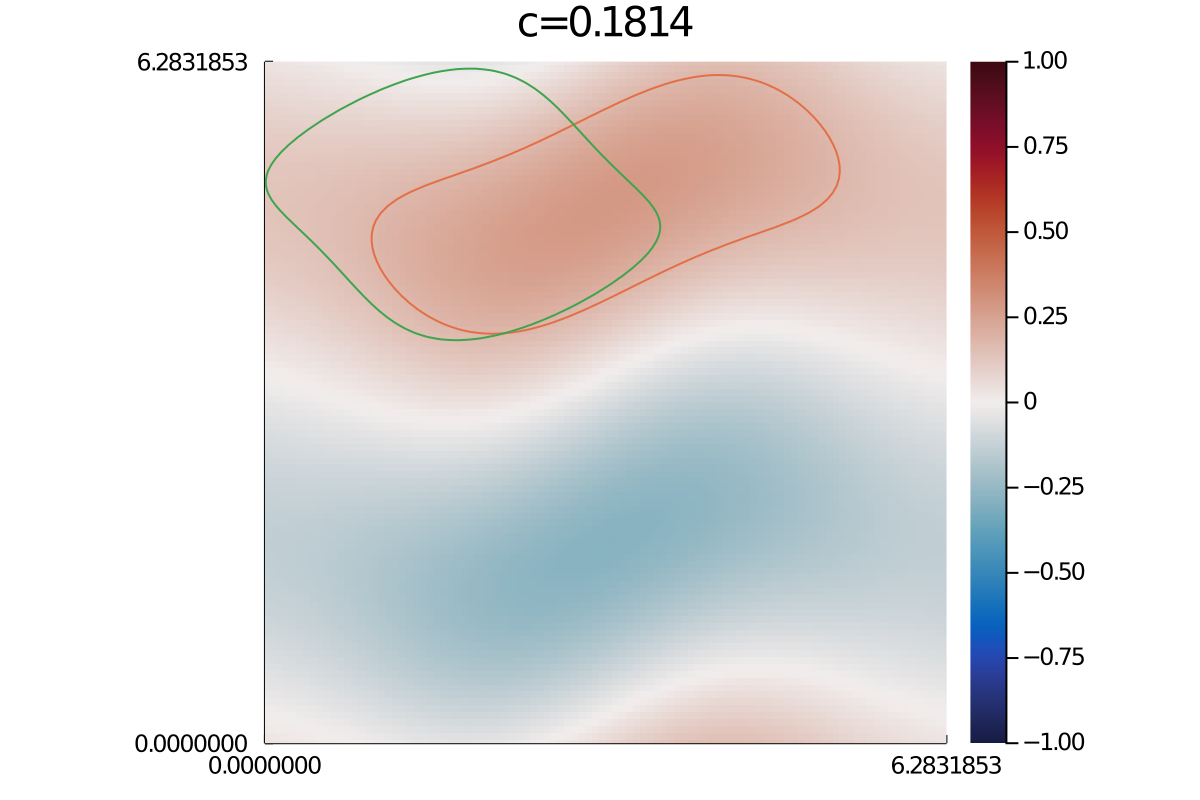

In [47]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value_levelset,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀[:,ev], c_best, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,2π),ylims=(0,2π))

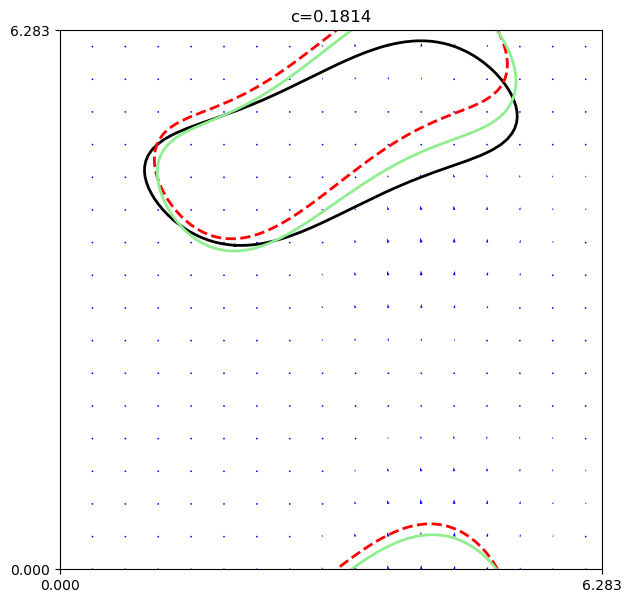

In [48]:
using PyCall
using PyPlot
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0,2π), ylim=(0,2π), xticks=(0,2π), yticks=(0,2π))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev], bdata=bdata)...,ax,scale=25,step=6)
curves           = lines(get_levelset(ctx, u₀[:,ev], c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev], c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev], c_best, bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [27]:
μ = 0.99/grid_resolution;

In [28]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false,maxiter=100000);

 22.132880 seconds (10.61 M allocations: 44.914 GiB, 13.22% gc time)


In [29]:
inv(qr(u₀).R)*R'

7×7 Array{Float64,2}:
 -0.0247699   0.0227192   0.0227391   …   0.0238241  -0.0251463   0.0247546
 -0.118344    0.0140249   0.0763794      -0.100404    0.0907228   0.117054
  0.110745    0.0270452  -0.110561        0.0706644  -0.0840523  -0.106962
 -0.0038741   0.0137993   0.0342921      -0.013307    0.0284032  -0.0314432
 -0.03311    -0.0316886  -0.00567475     -0.0297614  -0.0219902  -0.0116368
 -0.145901    0.0699551  -0.0546412   …   0.095137   -0.0143022  -0.15739
  0.122972   -0.0869912   0.0315514      -0.0671378   0.0533824   0.166273

In [30]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [31]:
Sprime = Matrix(qr(u₀).Q)*R';

In [32]:
Sdot = u_dot*inv(qr(u₀).R)*R';

In [33]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false,maxiter=100000);

In [34]:
Sϵprime = Matrix(qr(uϵ).Q)*Rϵ';

##### Compare different ways to arrive at a similar result

In [49]:
cmins = [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
cmaxs = -1 .* cmins
cmins_lr = [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
cmaxs_lr = -1 .* cmins_lr;

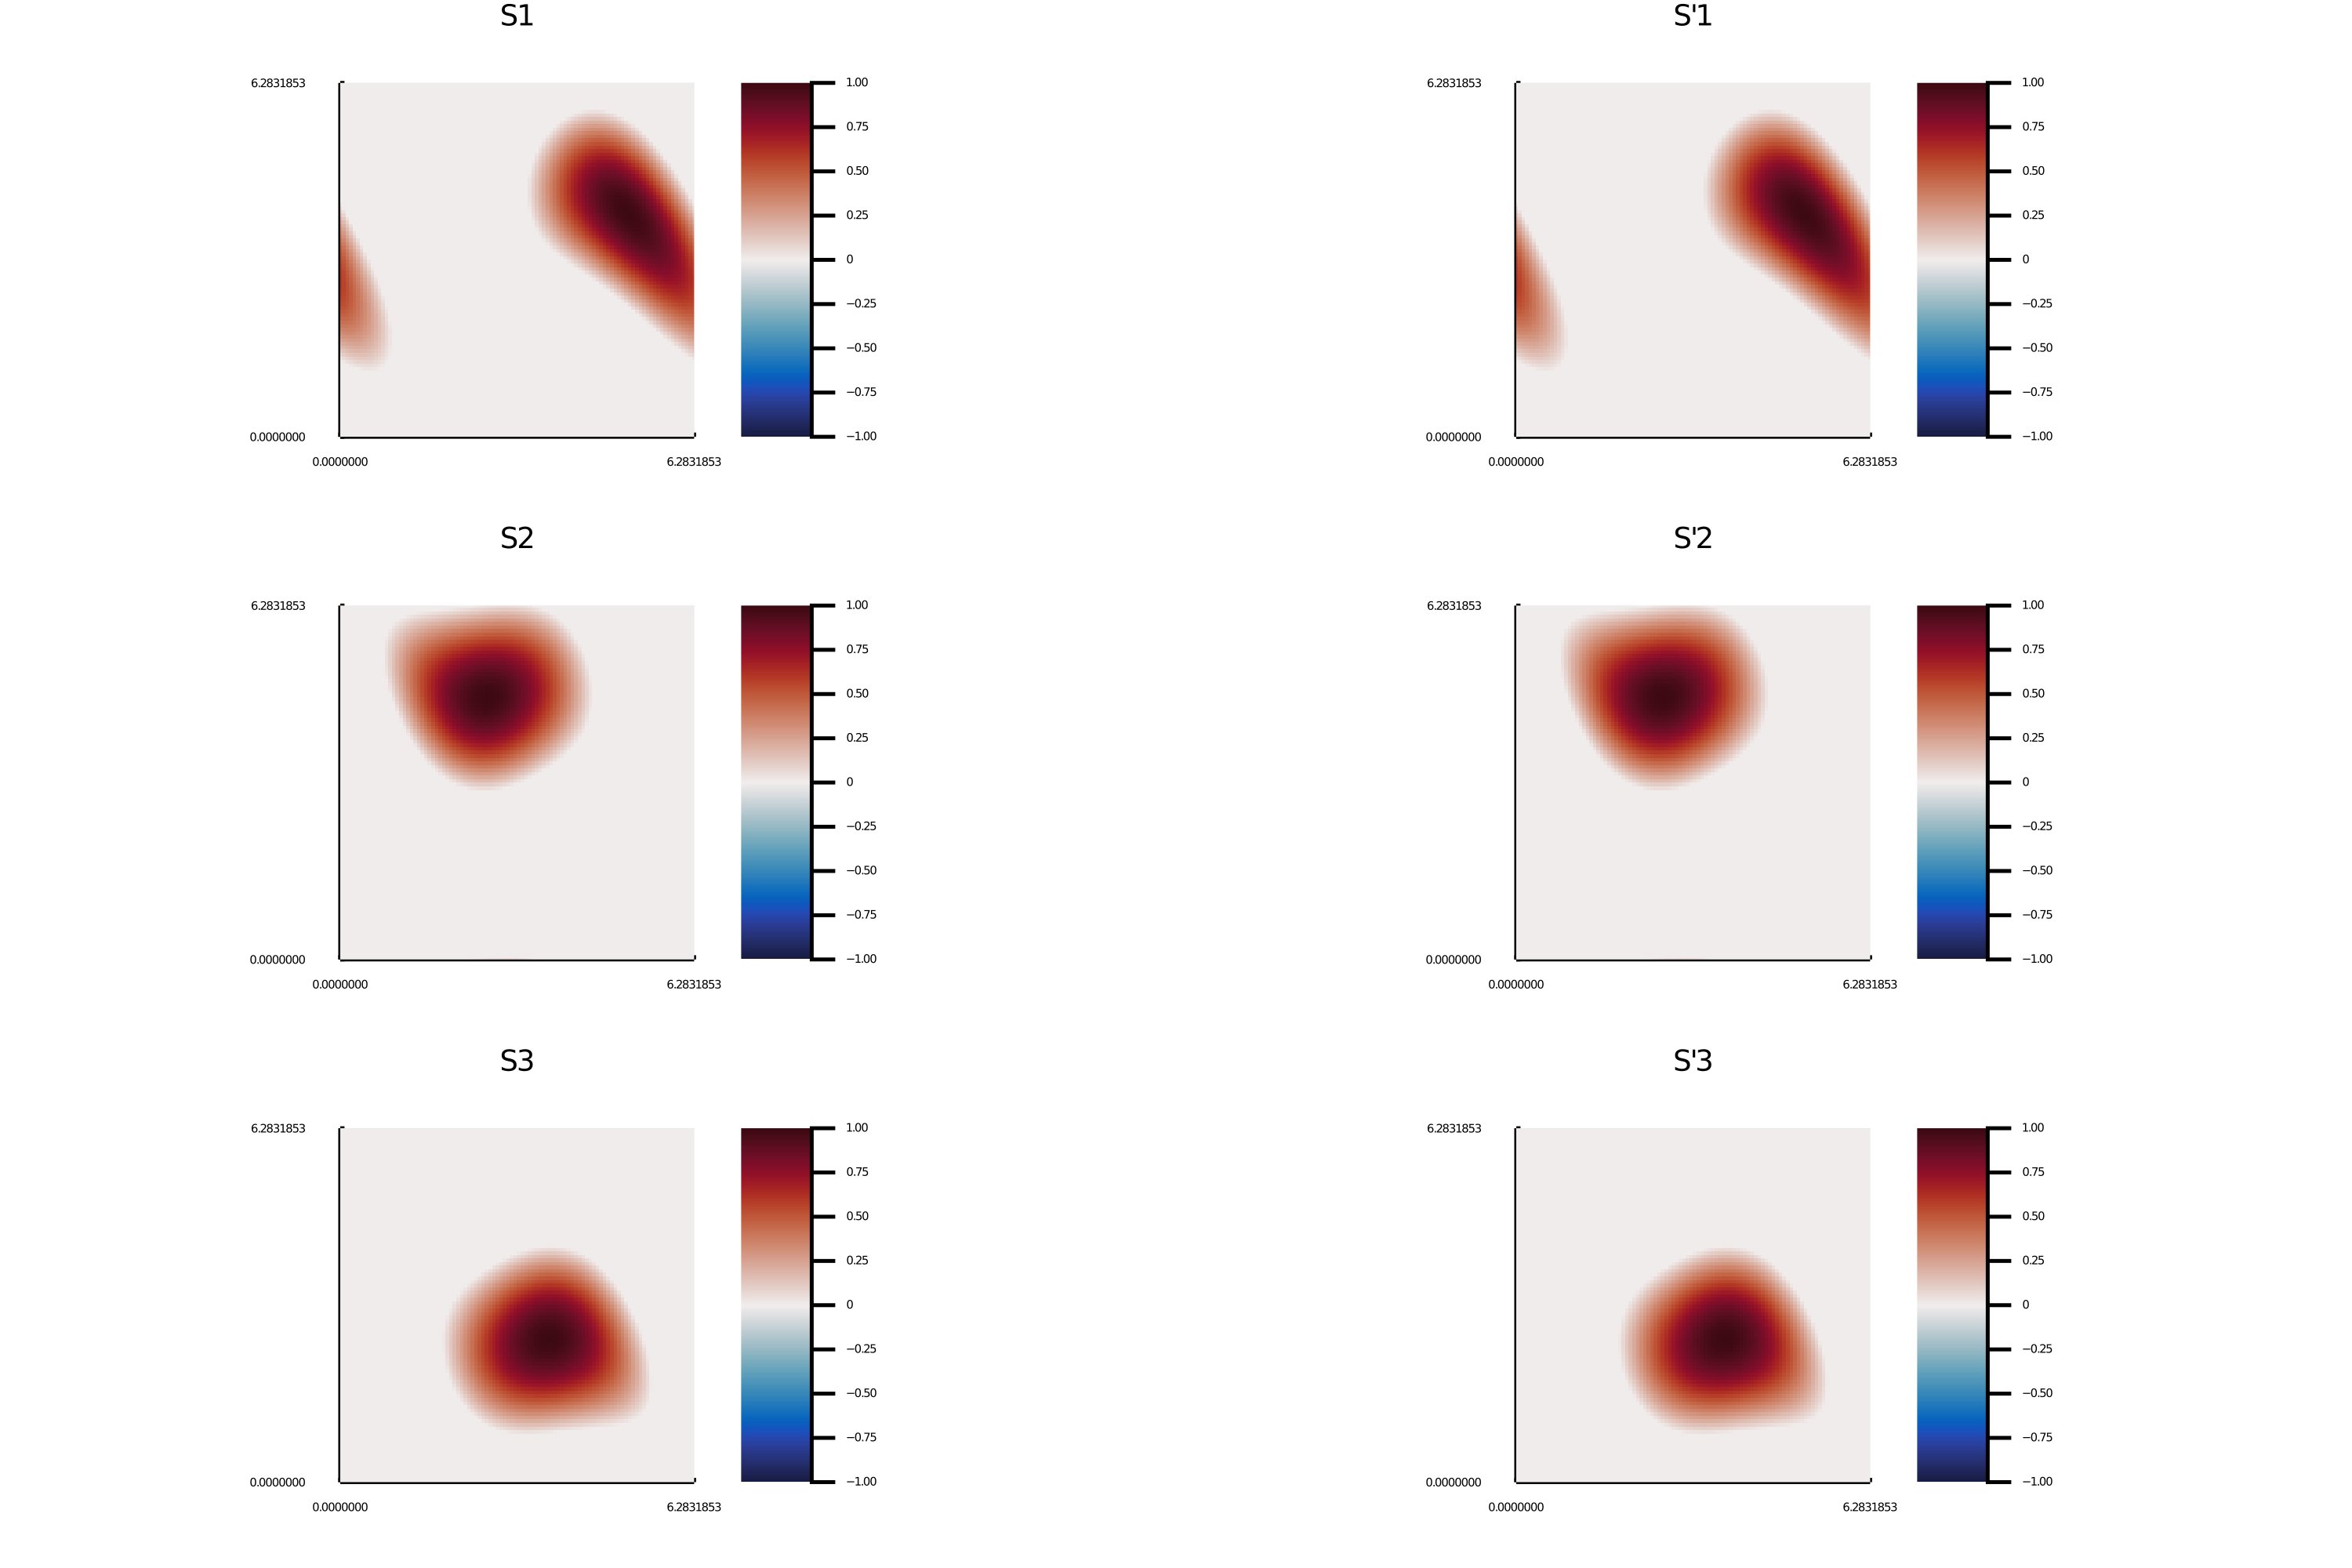

In [53]:
plots = []
for i in 1:3
    push!(plots,plot_u(ctx, S[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="S"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(3,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

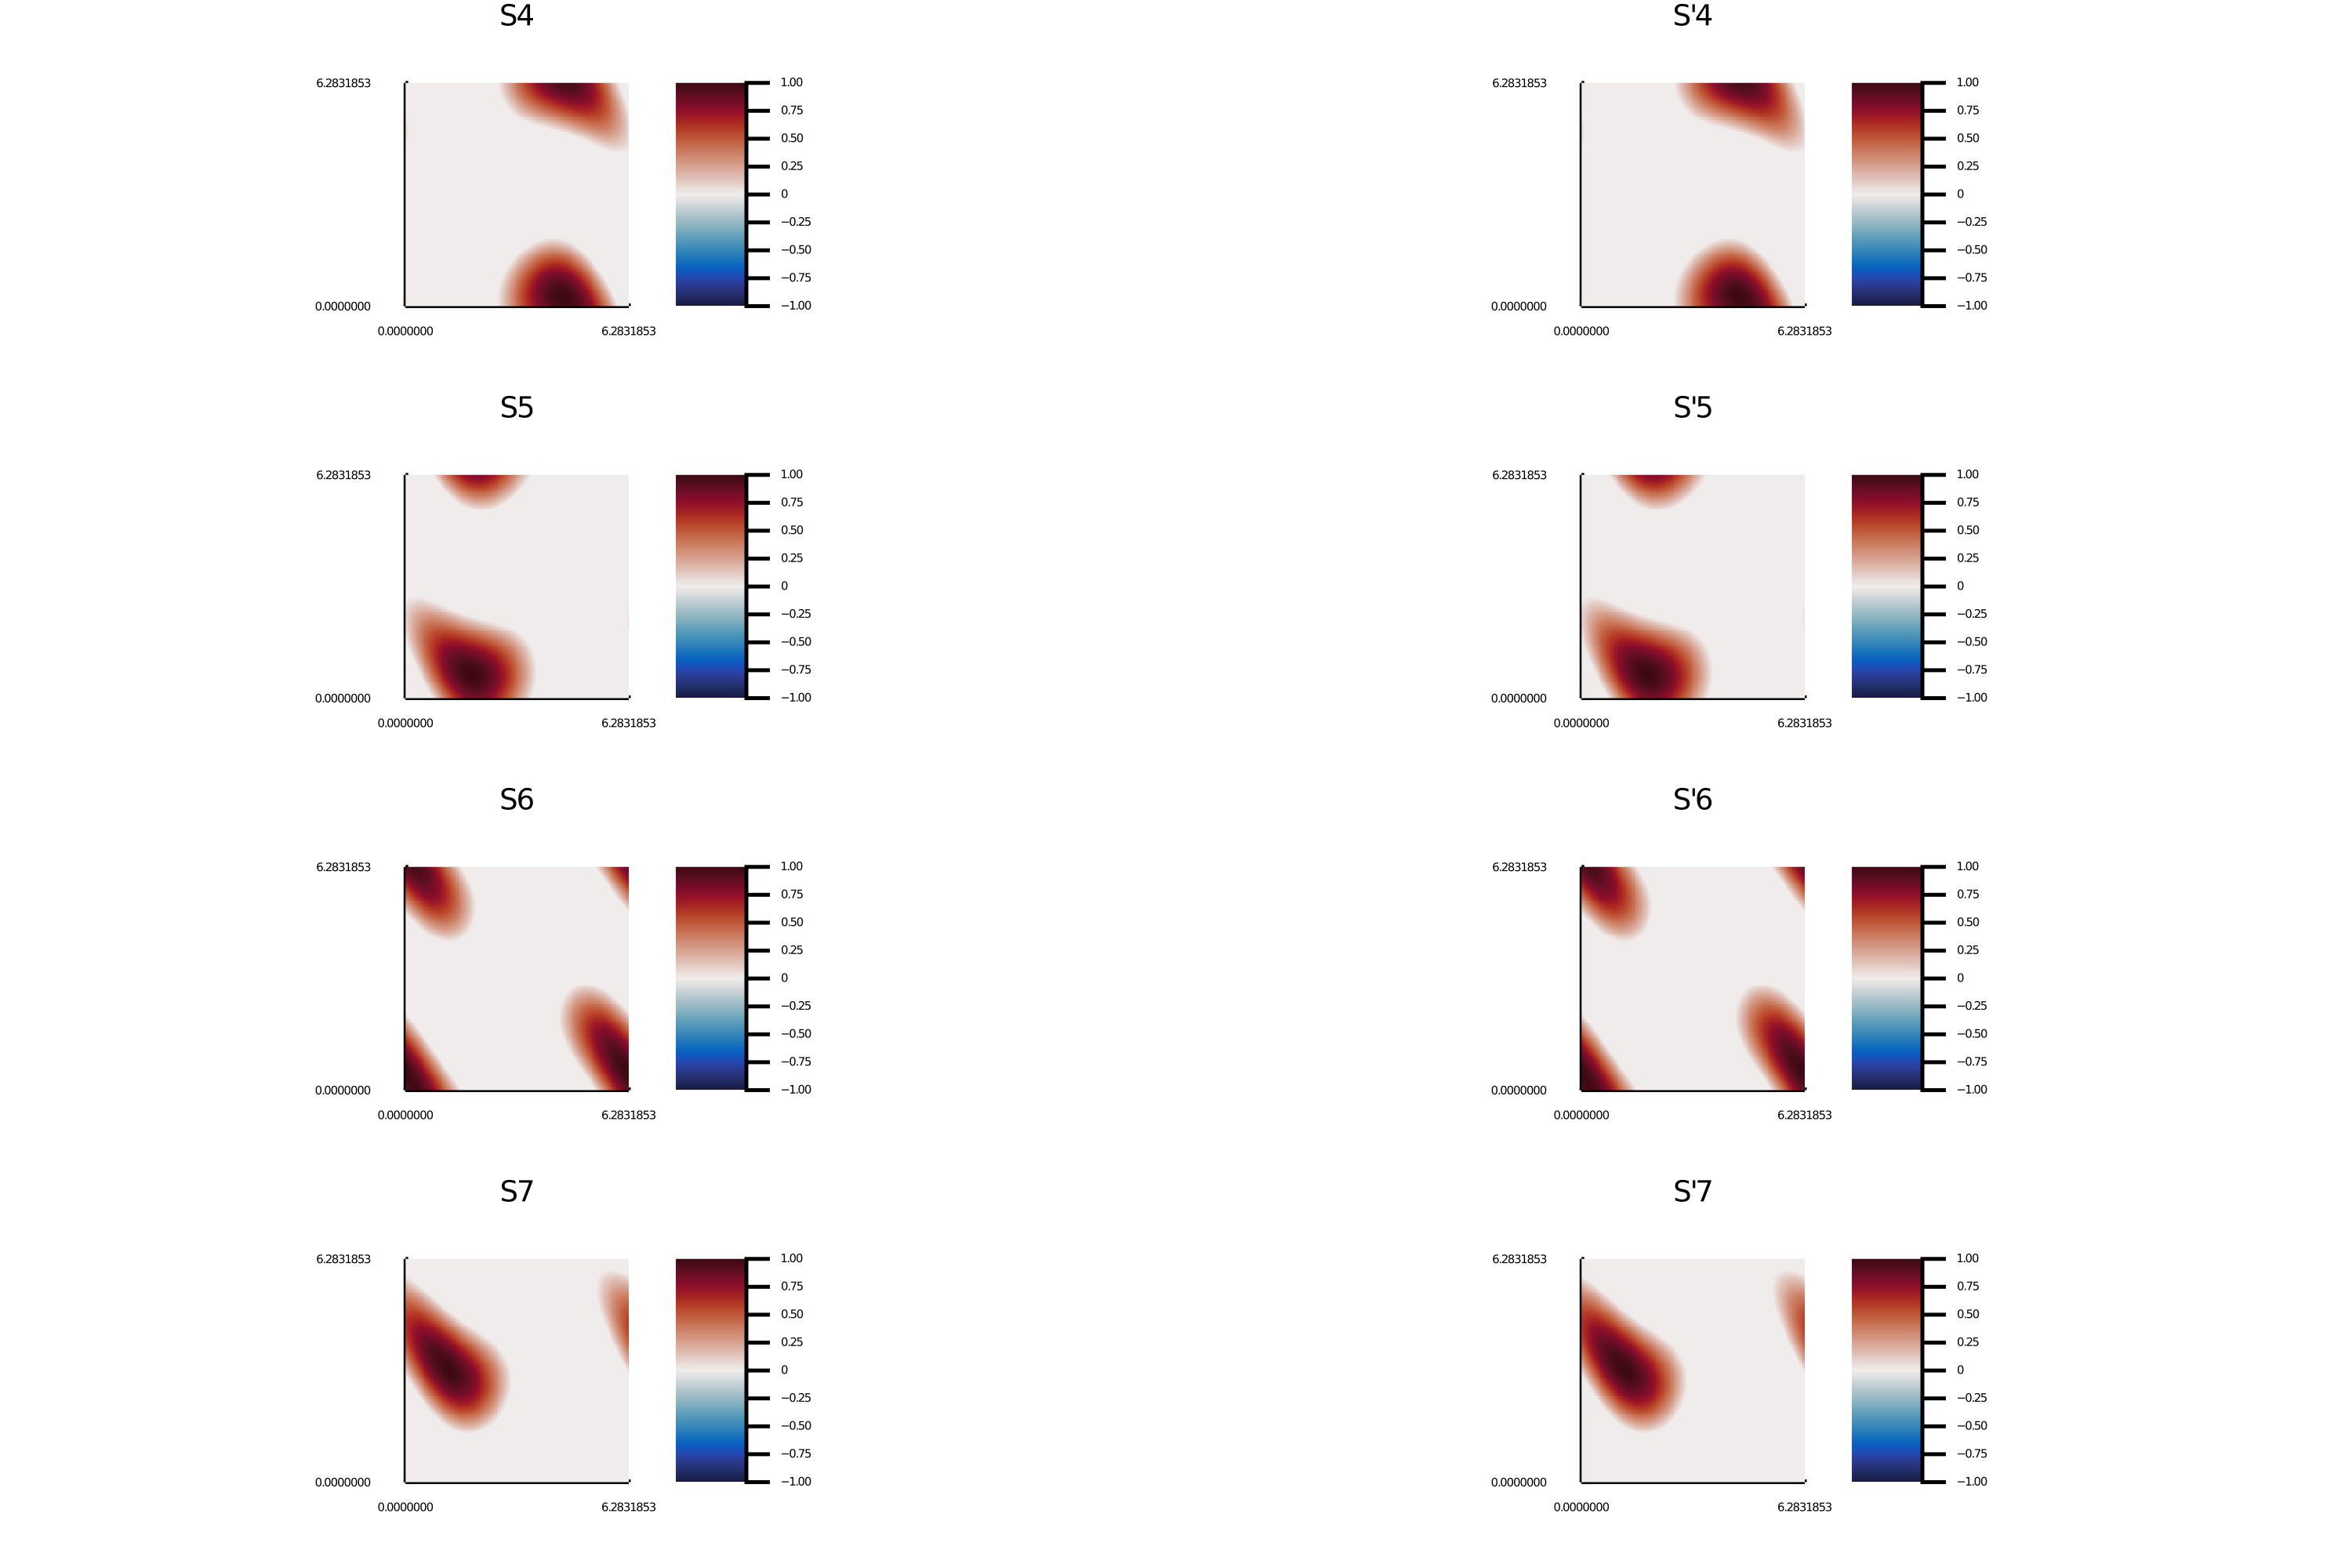

In [54]:
plots = []
for i in 4:nev
    push!(plots,plot_u(ctx, S[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="S"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev-3,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

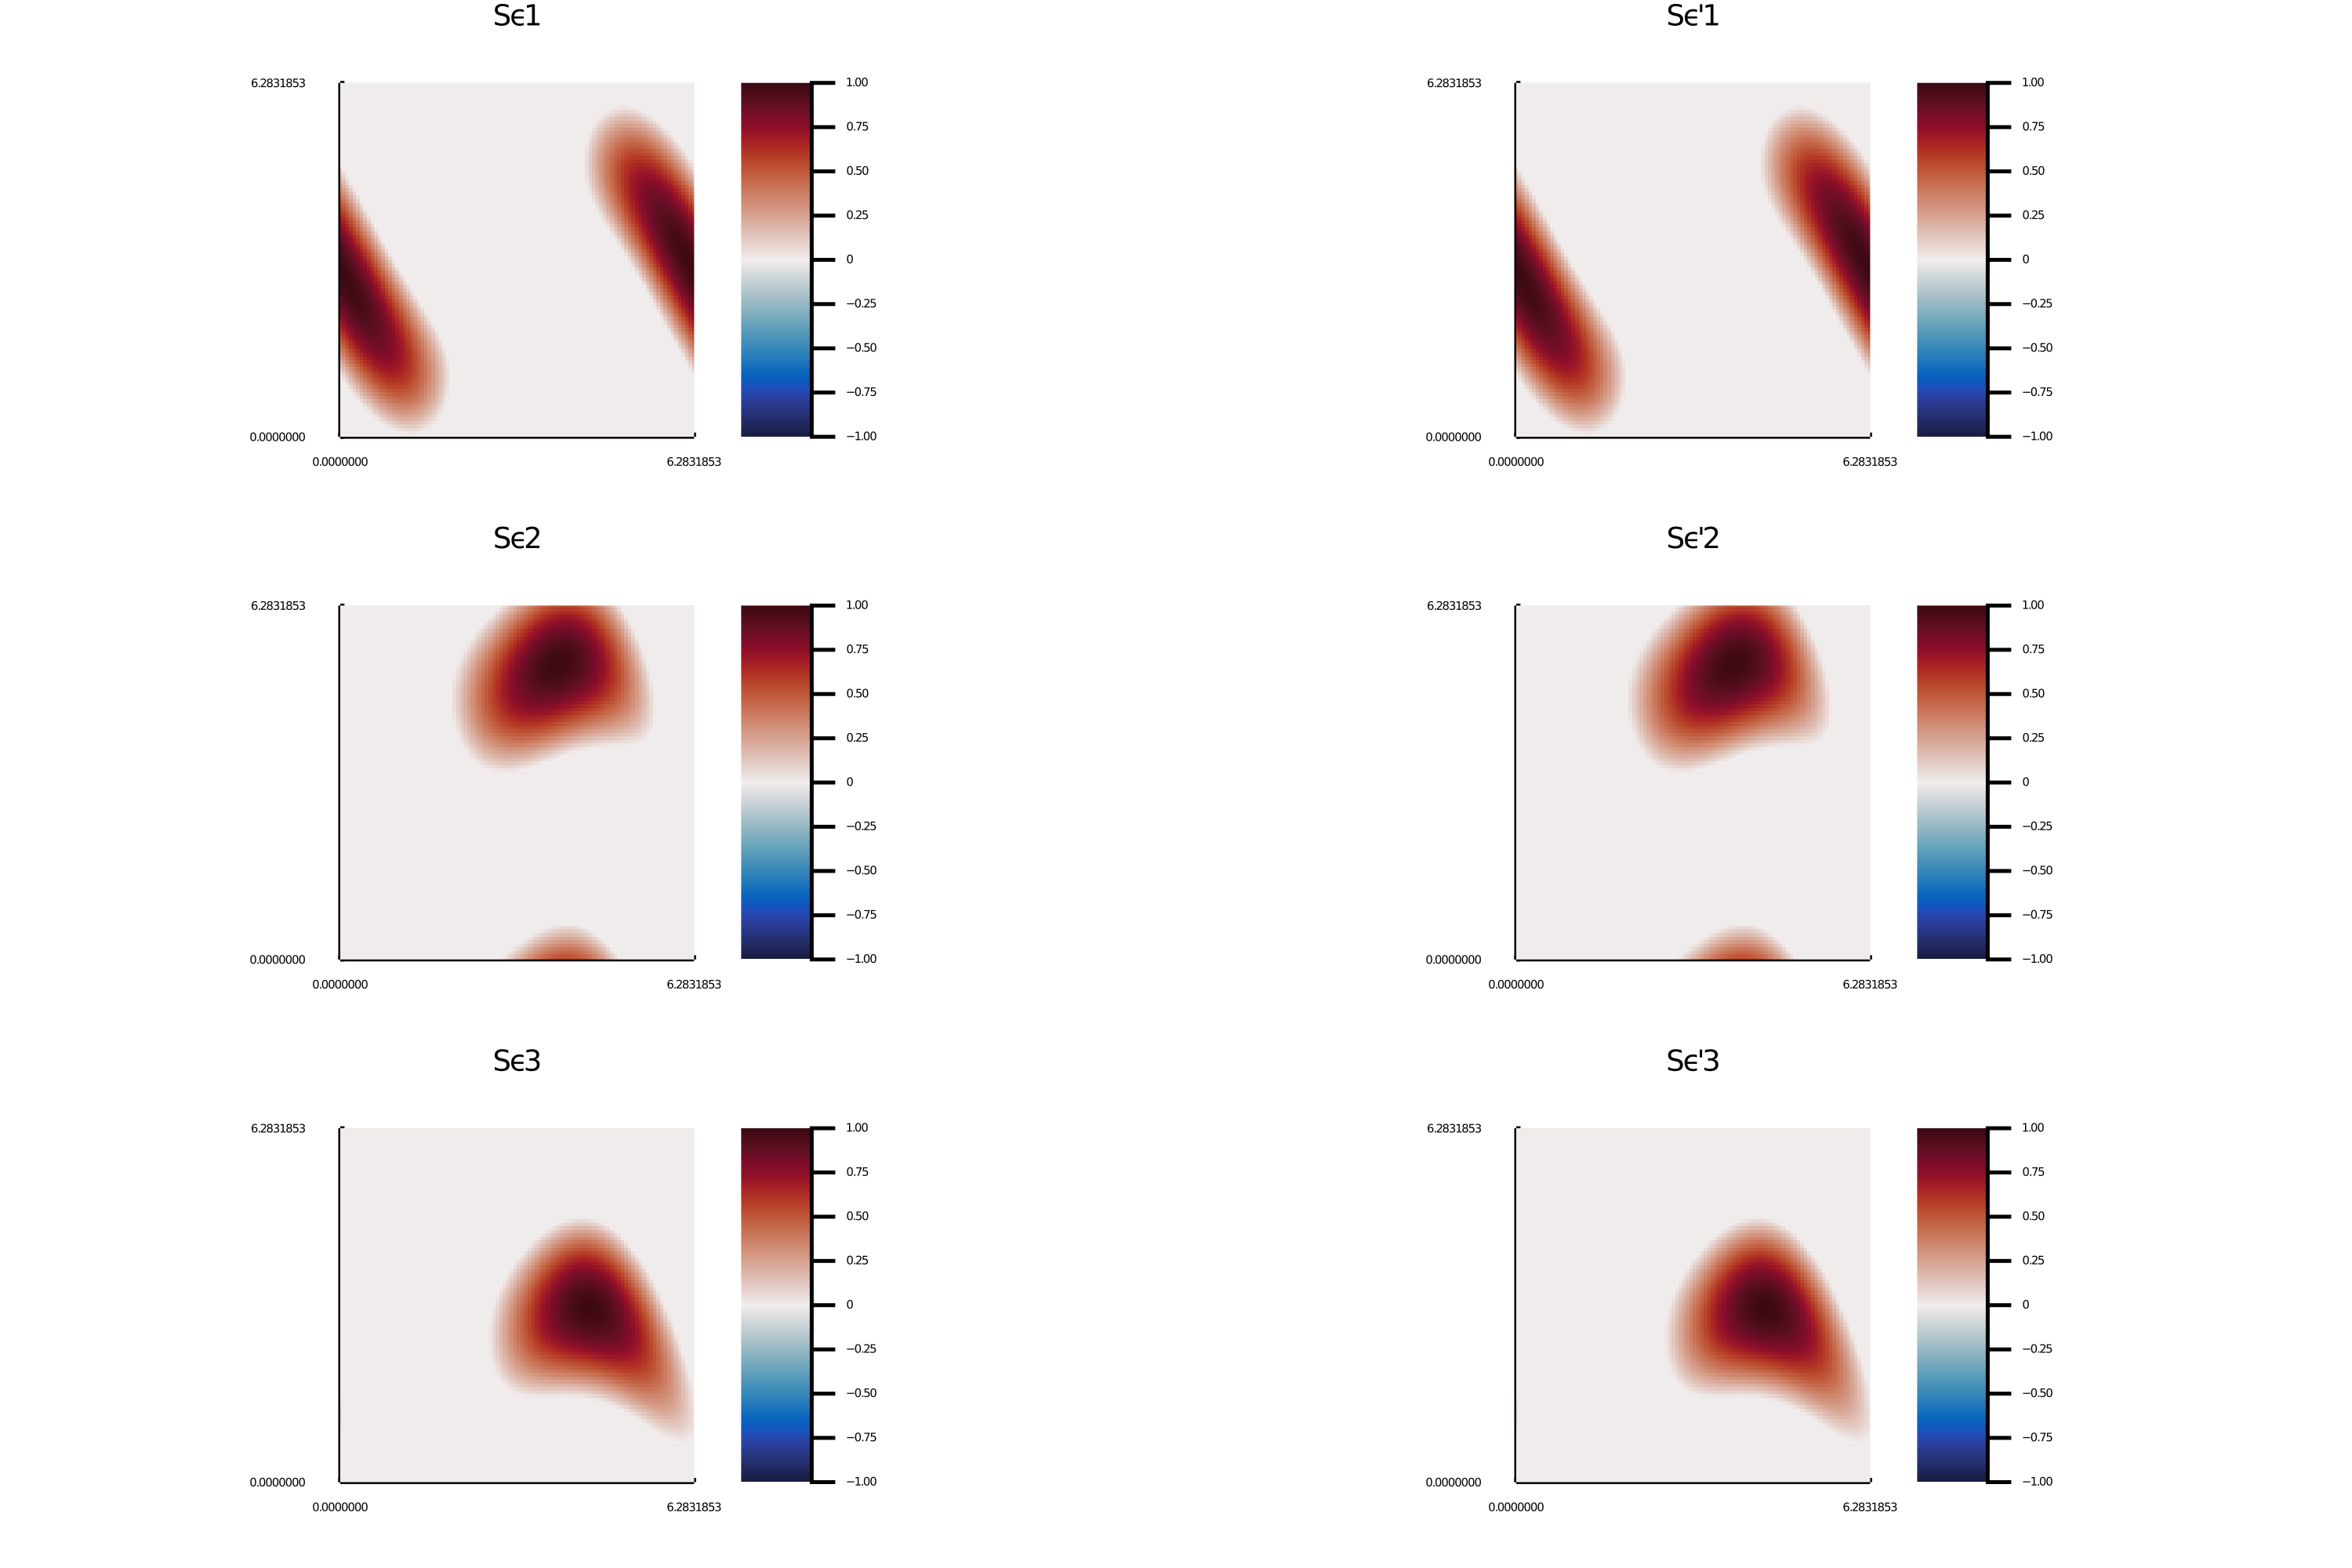

In [68]:
plots = []
for i in 1:3
    push!(plots,plot_u(ctx, Sϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sϵprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(3,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

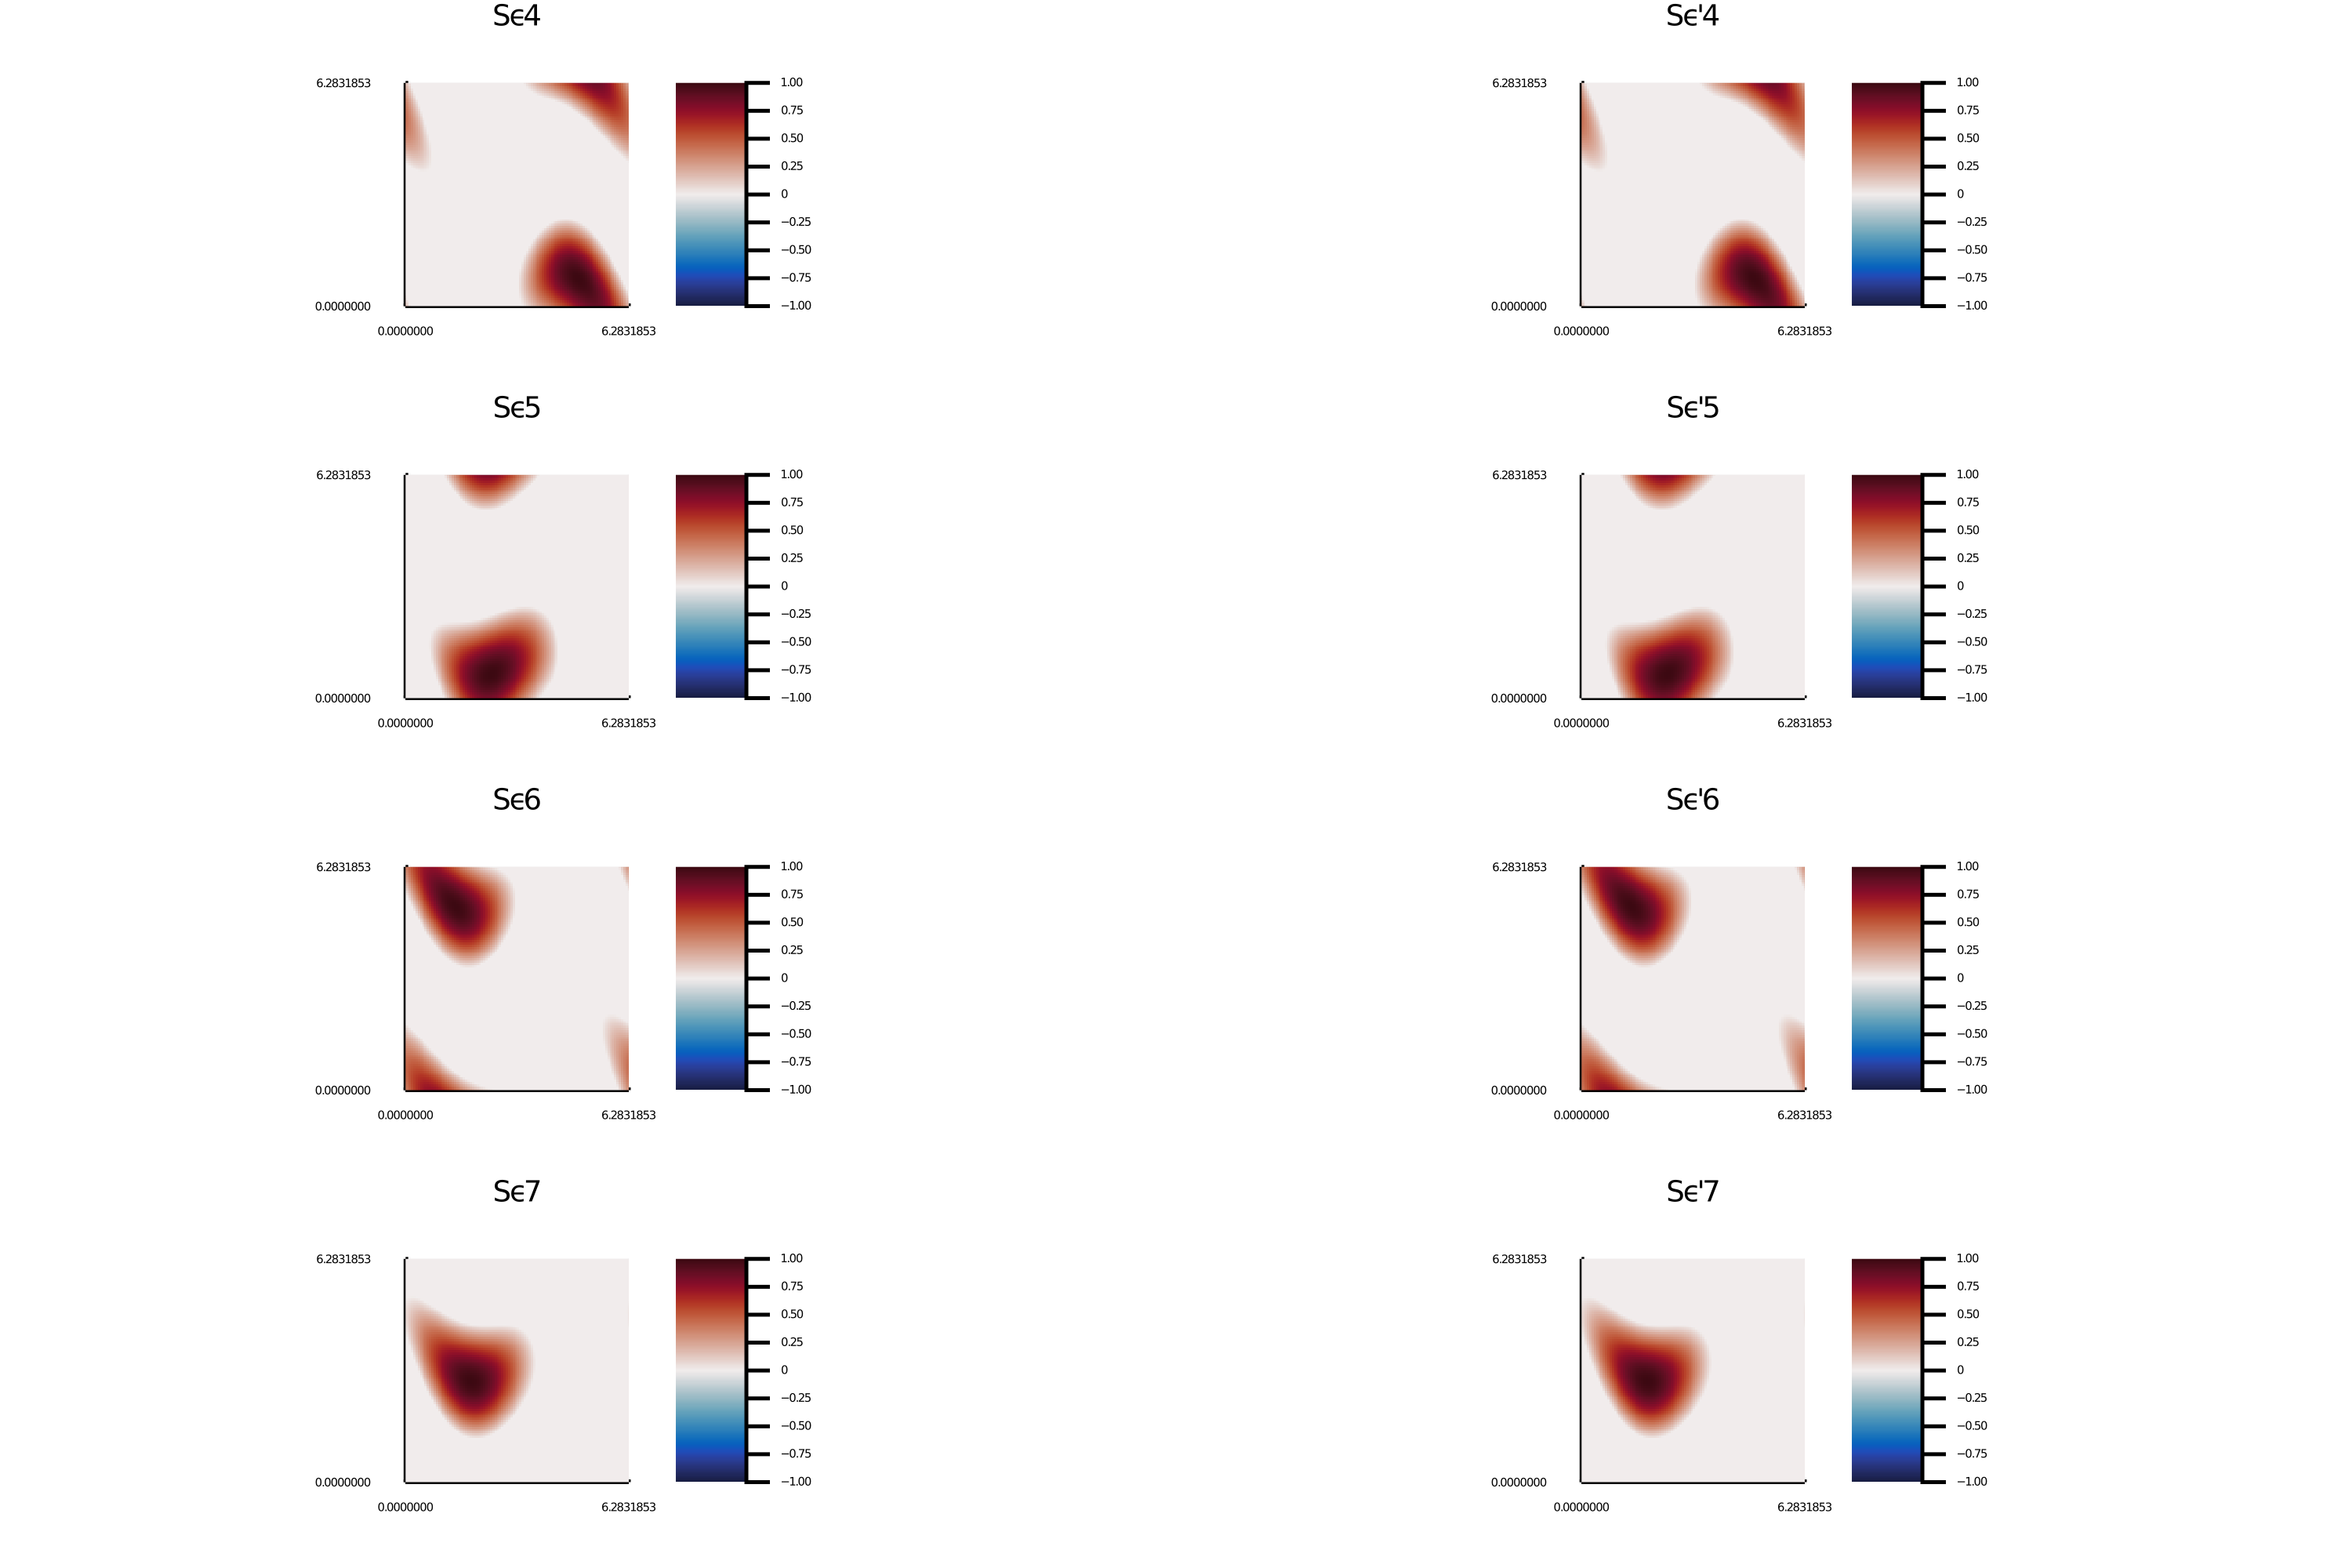

In [67]:
plots = []
for i in 4:nev
    push!(plots,plot_u(ctx, Sϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sϵprime[:,i],μ)), grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev-3,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [65]:
# reorder where neccessary
Sϵ = Sϵ[:,[7,4,5,6,3,1,2]]
Sϵprime = Sϵprime[:,[7,4,5,6,3,1,2]];

### Prediction

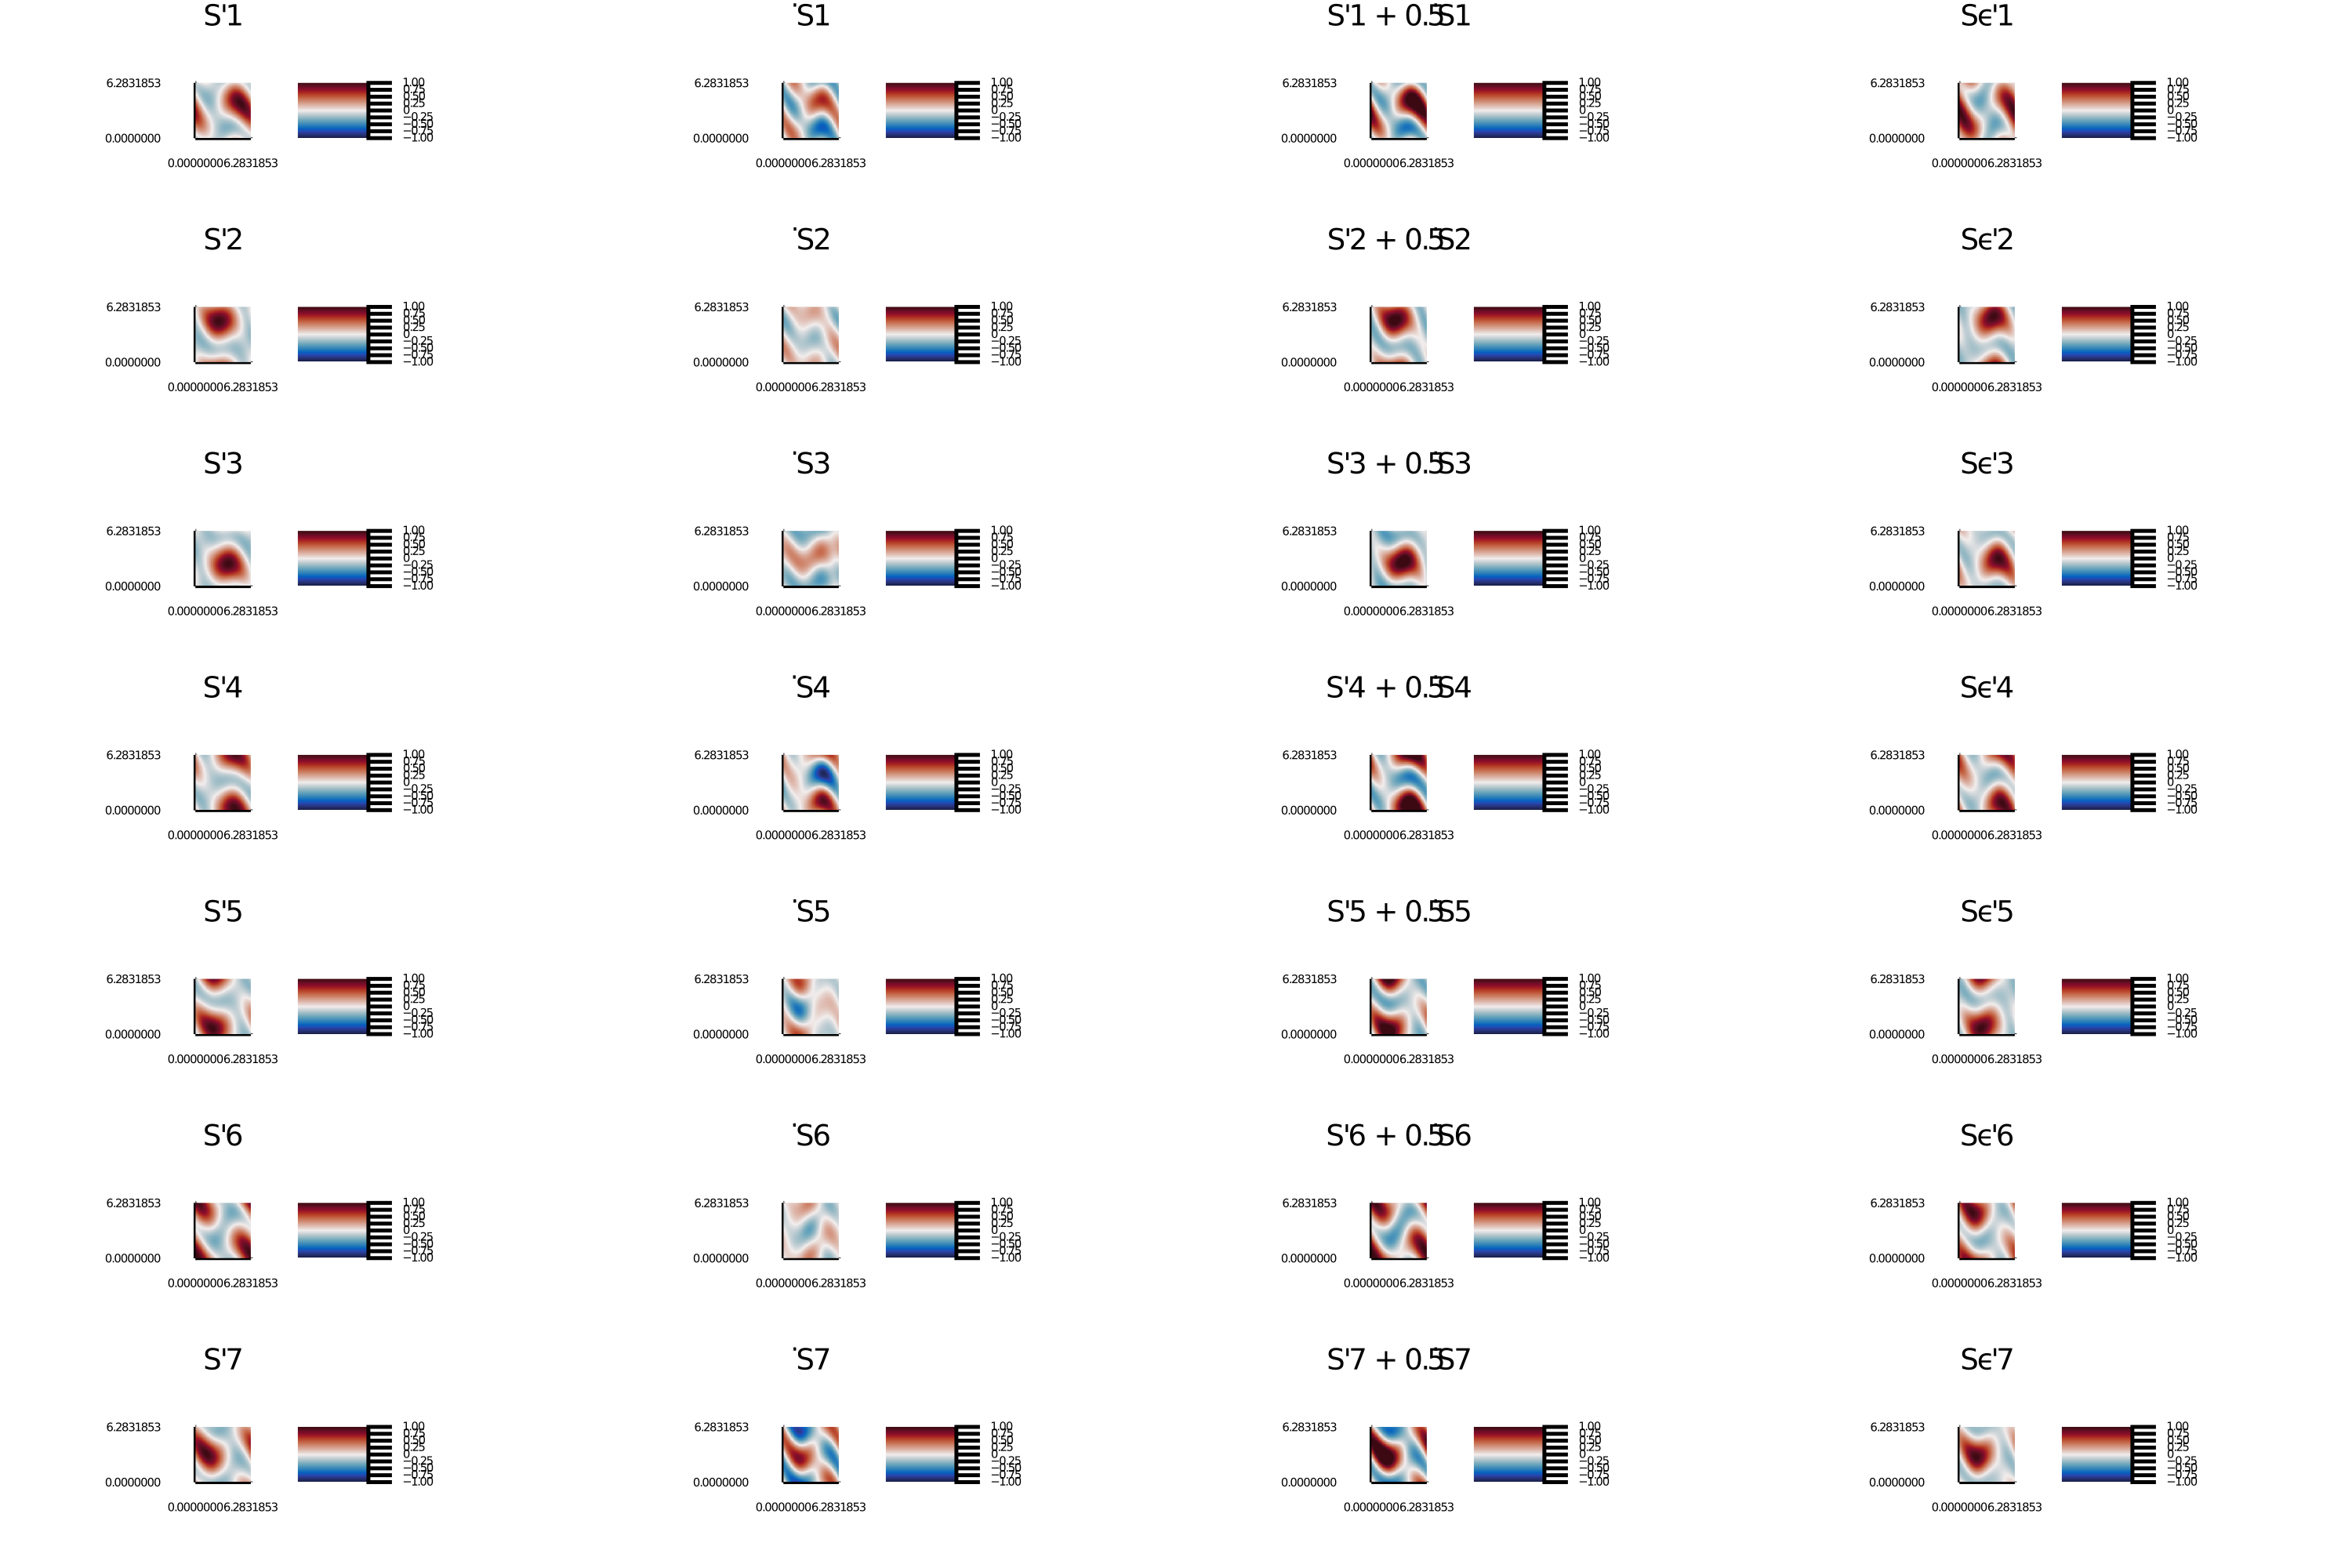

In [66]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="̇S"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sprime[:,i] + ϵ*Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i)*" + $(ϵ)̇S"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

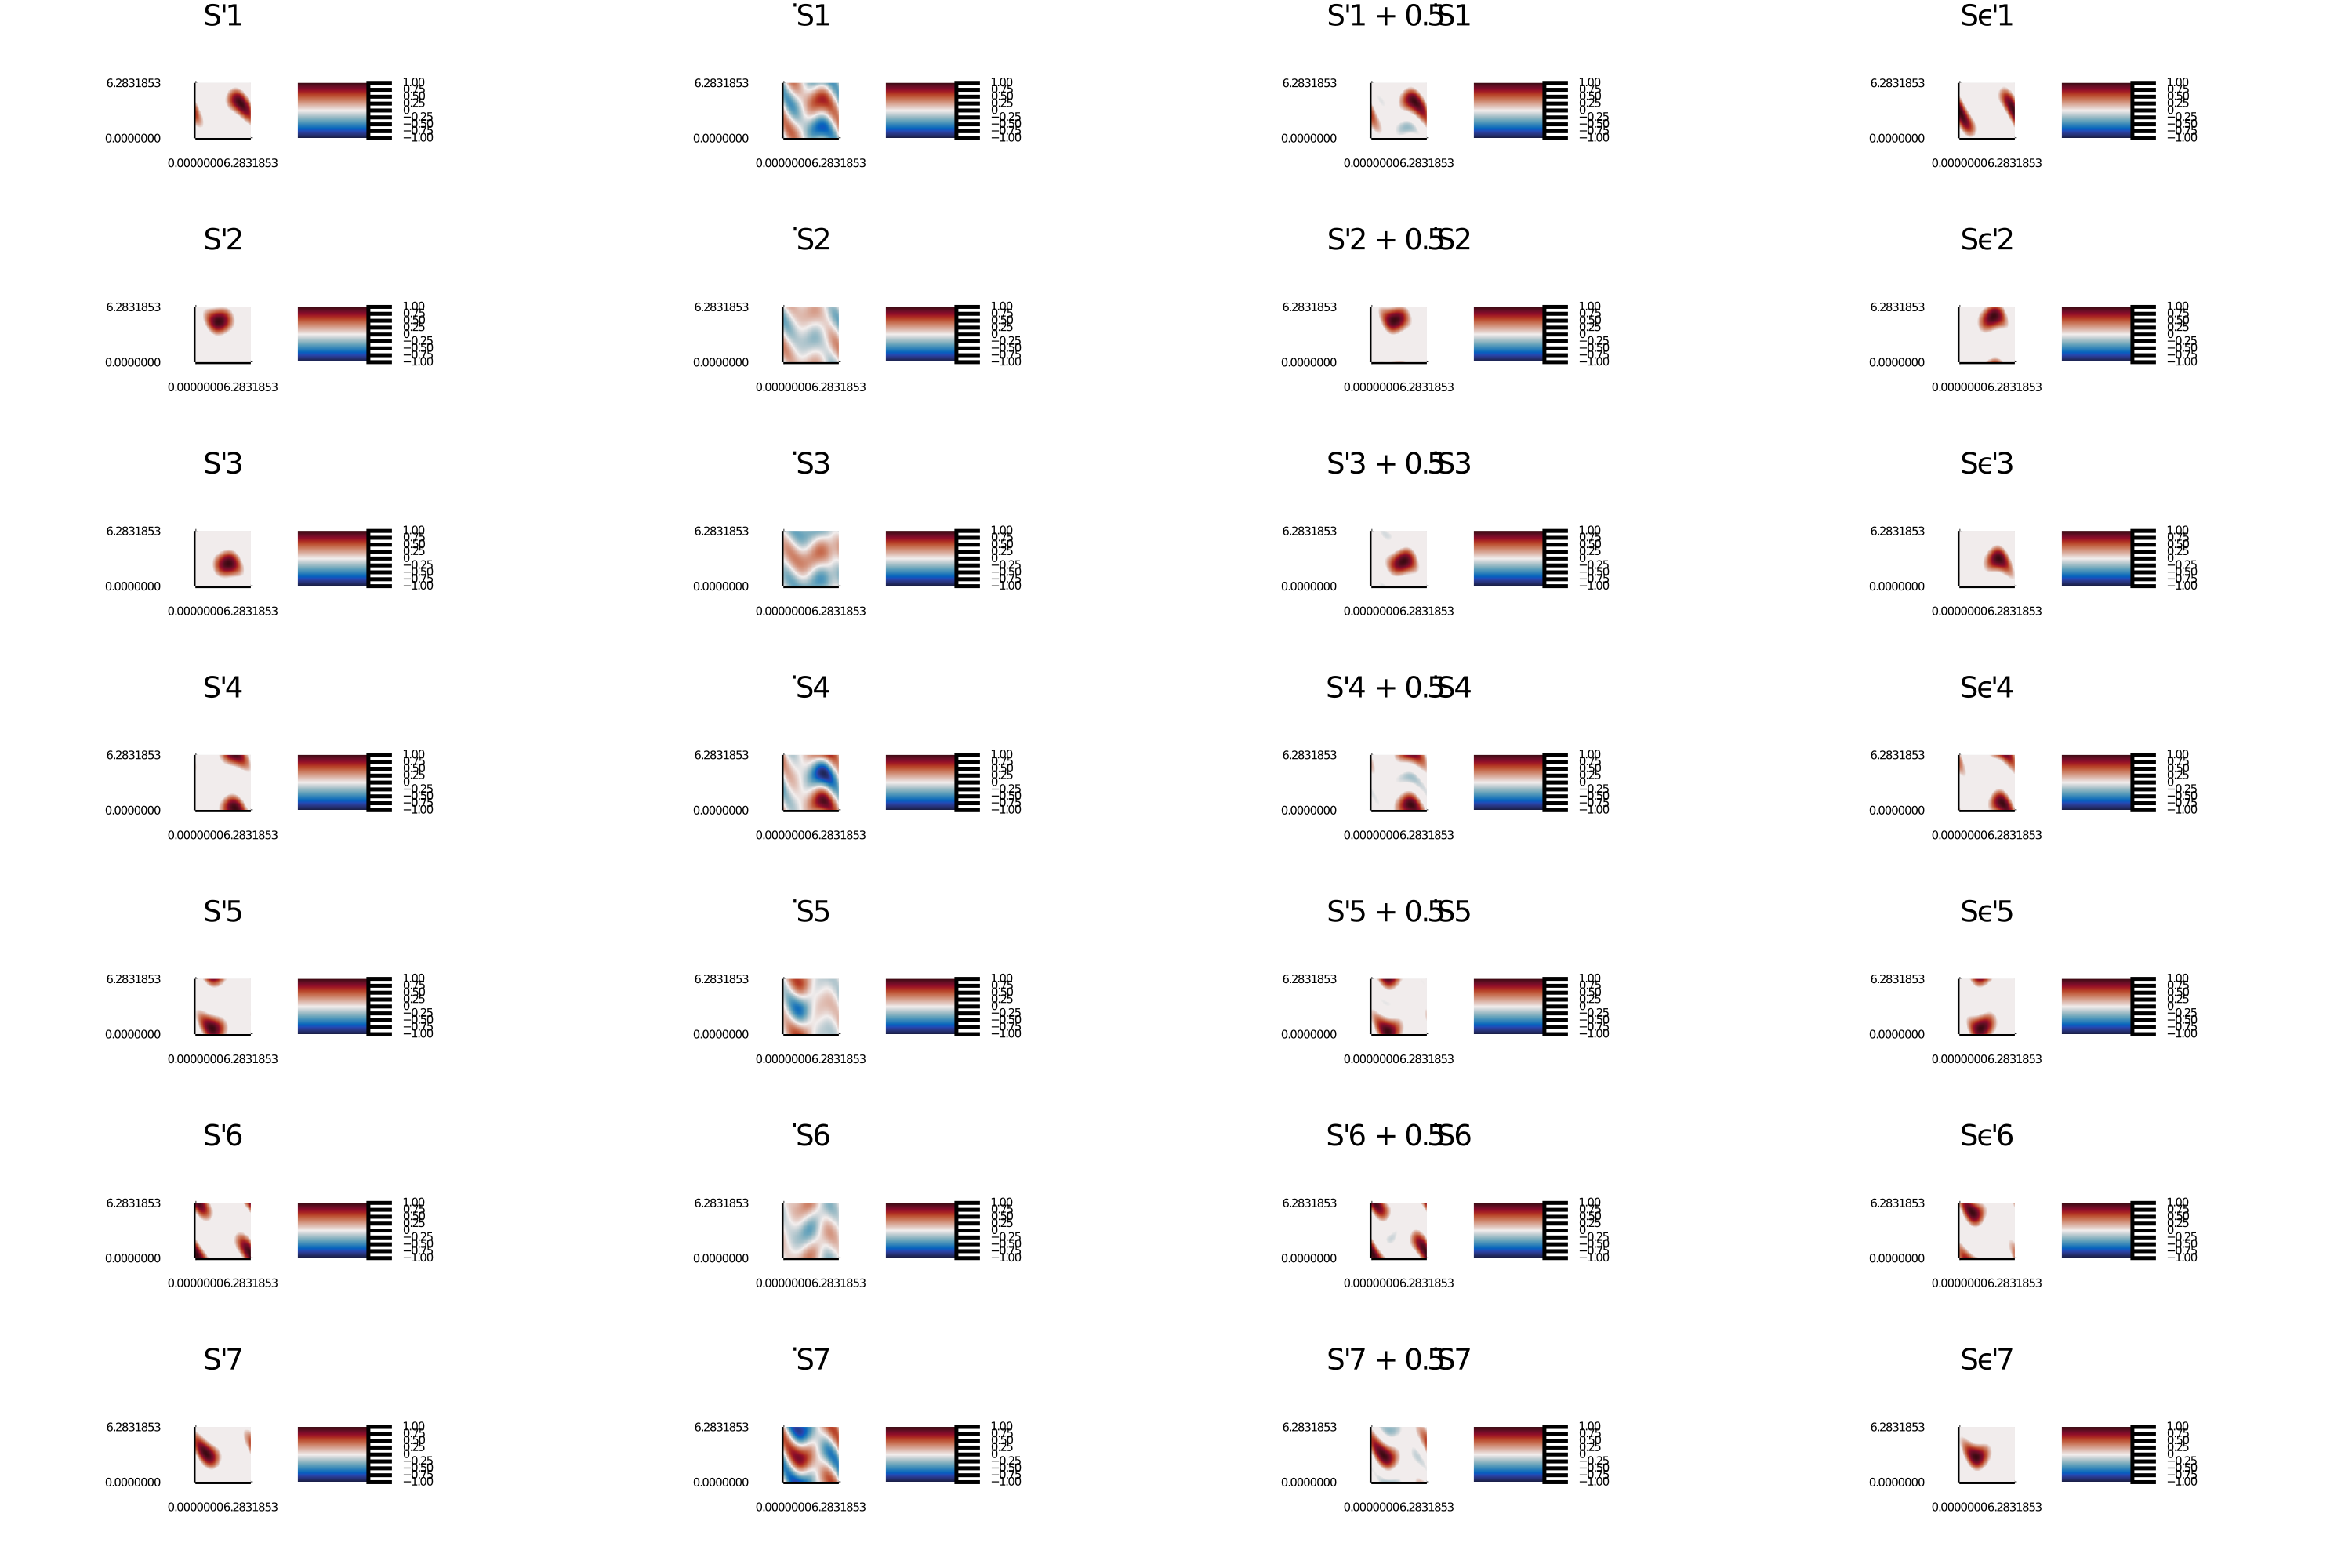

In [69]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sdot[:,i],Sprime[:,i]),  grid_resolution, grid_resolution, bdata=bdata,
            title="̇S"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(Sprime[:,i] + ϵ*Sdot[:,i],μ)),  grid_resolution, grid_resolution, bdata=bdata,
            title="S'"*string(i)*" + $(ϵ)̇S"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  grid_resolution, grid_resolution, bdata=bdata,
            title="Sϵ'"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [60]:
ev = 3;

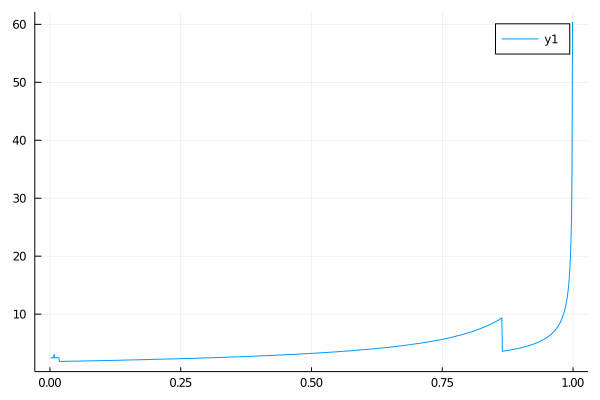

In [61]:
u_max = maximum(S[:,ev])
u_min = minimum(S[:,ev])
values = []
for c in range(u_min,stop=u_max,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c, bdata=bdata)
    if (length(lines(levelset))>0)
        push!(values,dynamic_cheeger_value_levelset(levelset))
    else 
        push!(values,0)
    end
end
Plots.plot(range(u_min,stop=u_max,length=1000)[2:end-1],values[2:end-1])

Dynamic Cheeger value:	1.8398254776308605
Levelset:		0.017982017982017984
1.8398254776308605	11.268700654325652	24.3017162847942	9.666791054802601


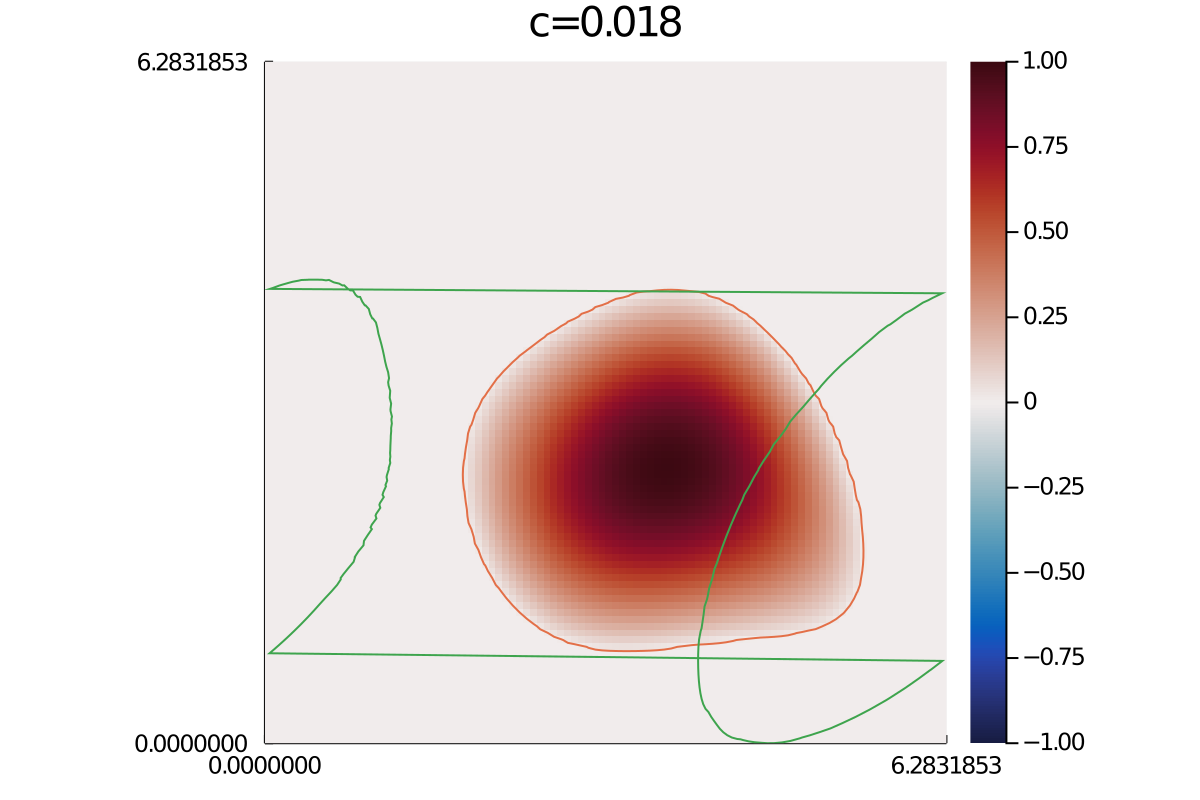

In [63]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value_levelset,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  grid_resolution, grid_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, S[:,ev], c_best, bdata=bdata))
curves_moved = [Main.CoherentStructures.apply2curve(T_static,c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,2π),ylims=(0,2π))

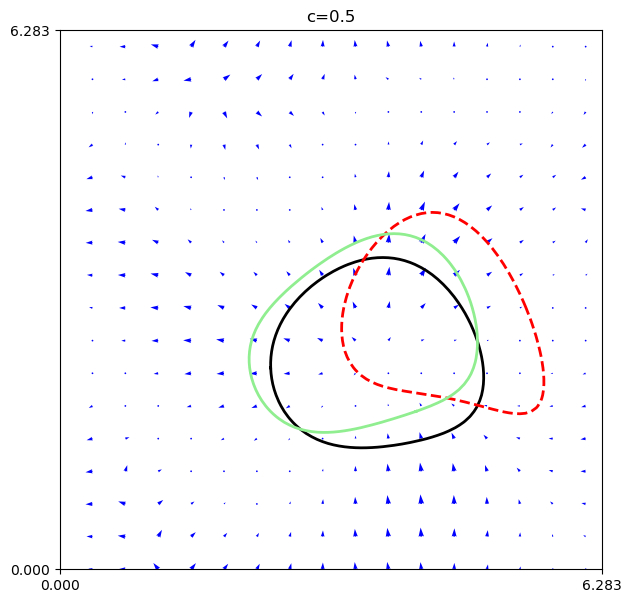

In [70]:
using PyCall
using PyPlot

c_best = 0.5

plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0,2π), ylim=(0,2π), xticks=(0,2π), yticks=(0,2π))
plot_vectorfield(
                get_levelset_evolution(ctx,normalizeU(Sprime[:,ev]),normalizeU(Sdot[:,ev],Sprime[:,ev]),bdata=bdata)...,
                ax,scale=25,step=6)
curves           = lines(get_levelset(ctx, S[:,ev], c_best, bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev], c_best, bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(Sprime[:,ev] + ϵ*Sdot[:,ev],μ)), c_best, bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");